In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

In [3]:
warnings.filterwarnings("ignore")

### Carregando dataset

In [4]:
df_train = pd.read_csv('../data/treated_data/train.csv', sep=';')
df_val = pd.read_csv('../data/treated_data/val.csv', sep=';')
df_test = pd.read_csv('../data/treated_data/test.csv', sep=';')

In [5]:
X_train = df_train.drop(['rating'], axis=1)
y_train = df_train['rating'].values

X_val = df_val.drop(['rating'], axis=1)
y_val = df_val['rating'].values

X_test = df_test.drop(['rating'], axis=1)
y_test = df_test['rating'].values

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

### Criando o modelo base

In [6]:
params = {
    'max_depth': 8,
    'eta': 0.2,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'max_delta_step': 3,
    'lambda': 1,
    'alpha': 0,
    'num_class': 3
}

In [7]:
model = xgb.train(
    params,
    dtrain,
    1000,
    evals=[(dval, 'validation')],
    early_stopping_rounds=5,
    verbose_eval=100
)

[0]	validation-mlogloss:0.99541
[100]	validation-mlogloss:0.64169
[169]	validation-mlogloss:0.63536


In [8]:
y_pred_probs = model.predict(dtest)
y_pred = y_pred_probs.argmax(axis=1)

In [9]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.2f}')

Acurácia do modelo: 0.72


### Grid Search para encontrar os melhores hiperparâmetros

In [10]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

In [11]:
param_grid = {
    'max_depth': [6, 8, 10],
    'eta': [0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'lambda': [1, 2],
    'alpha': [0, 0.5]
}

In [12]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [13]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.5], 'eta': [0.1, 0.2], 'lambda': [1, 2],
                         'max_depth': [6, 8, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=2)

In [14]:
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
print(f"Melhor acurácia obtida: {grid_search.best_score_:.2f}")

Melhores hiperparâmetros: {'alpha': 0.5, 'eta': 0.2, 'lambda': 1, 'max_depth': 10, 'n_estimators': 150}
Melhor acurácia obtida: 0.82


In [15]:
best_model = grid_search.best_estimator_

### Salvando o melhor modelo

In [ ]:
with open('../models/xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

### Avaliando o modelo

Primeiro vamos carregar o modelo salvo, para não ser necessário rodar todo o notebook novamente.

In [7]:
# Carregando o modelo salvo
with open('../models/xgboost_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [8]:
y_pred = model.predict(X_test)
y_pred_scores = model.predict_proba(X_test)

In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1_score:.2f}')

Acurácia: 0.73
Precisão: 0.68
Recall: 0.69
F1-Score: 0.68


In [10]:
cm = confusion_matrix(y_test, y_pred)

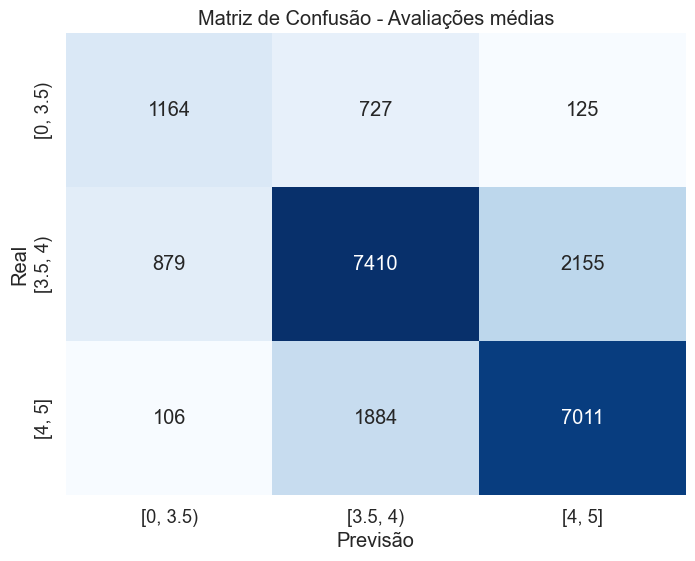

In [11]:
# Criando a matriz de confusão

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['[0, 3.5)', '[3.5, 4)', '[4, 5]'], yticklabels=['[0, 3.5)', '[3.5, 4)', '[4, 5]'])


plt.title('Matriz de Confusão - Avaliações médias')
plt.xlabel('Previsão')
plt.ylabel('Real')

plt.show()

A análise dos resultados obtidos revela que o modelo de classificação de XGBoost treinado tem um resultado razoável, muito próximo ao resultado obtido com o modelo de Random Forest, possuindo uma acurácia de 0.73 e um F1-Score de 0.68, o que indica um equilíbrio entre precisão e recall. Porém, assim como na Random Forest, a matriz de confusão mostra erros significativos entre as classes adjacentes.

Considerando esses dois resultados, pode-se perceber uma possível necessidade de melhoria no processamento dos dados para melhorar a separabilidade entre as classes.